In [2]:
# loading necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

%config InlineBackend.figure_format = 'retina'

In [4]:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

In [5]:
df = pd.read_csv("/content/churn.csv", index_col=0)

In [6]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
df.shape

(10000, 13)

In [9]:
df.info

<bound method DataFrame.info of            CustomerId                  Surname  CreditScore Geography  Gender  \
RowNumber                                                                       
1            15634602                 Hargrave          619    France  Female   
2            15647311                     Hill          608     Spain  Female   
3            15619304                     Onio          502    France  Female   
4            15701354                     Boni          699    France  Female   
5            15737888                 Mitchell          850     Spain  Female   
6            15574012                      Chu          645     Spain    Male   
7            15592531                 Bartlett          822    France    Male   
8            15656148                   Obinna          376   Germany  Female   
9            15792365                       He          501    France    Male   
10           15592389                       H?          684    France    Male

In [10]:
df.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
5%,1.557882e+07,489.000000,25.000000,1.000000,0.000000,1.000000,0.00000,0.000000,9851.818500,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
90%,1.579083e+07,778.000000,53.000000,9.000000,149244.792000,2.000000,1.00000,1.000000,179674.704000,1.000000
95%,1.580303e+07,812.000000,60.000000,9.000000,162711.669000,2.000000,1.00000,1.000000,190155.375500,1.000000


In [11]:
categorical_variables = [col for col in df.columns if col in "O"
                        or df[col].nunique() <=11
                        and col not in "Exited"]

categorical_variables

['Geography',
 'Gender',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember']

In [12]:
numeric_variables = [col for col in df.columns if df[col].dtype != "object"
                        and df[col].nunique() >11
                        and col not in "CustomerId"]
numeric_variables
['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [13]:
df["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [14]:
churn = df.loc[df["Exited"]==1]

In [15]:
not_churn = df.loc[df["Exited"]==0]

In [16]:
not_churn["Tenure"].value_counts().sort_values()

0     318
10    389
6     771
9     771
4     786
3     796
1     803
5     803
8     828
2     847
7     851
Name: Tenure, dtype: int64

In [17]:
churn["Tenure"].value_counts().sort_values()

0      95
10    101
7     177
6     196
8     197
2     201
4     203
5     209
3     213
9     213
1     232
Name: Tenure, dtype: int64

In [18]:
not_churn["NumOfProducts"].value_counts().sort_values()

3      46
1    3675
2    4242
Name: NumOfProducts, dtype: int64

In [19]:
churn["NumOfProducts"].value_counts().sort_values()

4      60
3     220
2     348
1    1409
Name: NumOfProducts, dtype: int64

In [20]:
# Frequency of churn group according to Gender
churn.Gender.value_counts()

Female    1139
Male       898
Name: Gender, dtype: int64

In [21]:
not_churn["CreditScore"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    7963.000000
mean      651.853196
std        95.653837
min       405.000000
5%        492.000000
25%       585.000000
50%       653.000000
75%       718.000000
90%       778.000000
95%       812.000000
99%       850.000000
max       850.000000
Name: CreditScore, dtype: float64

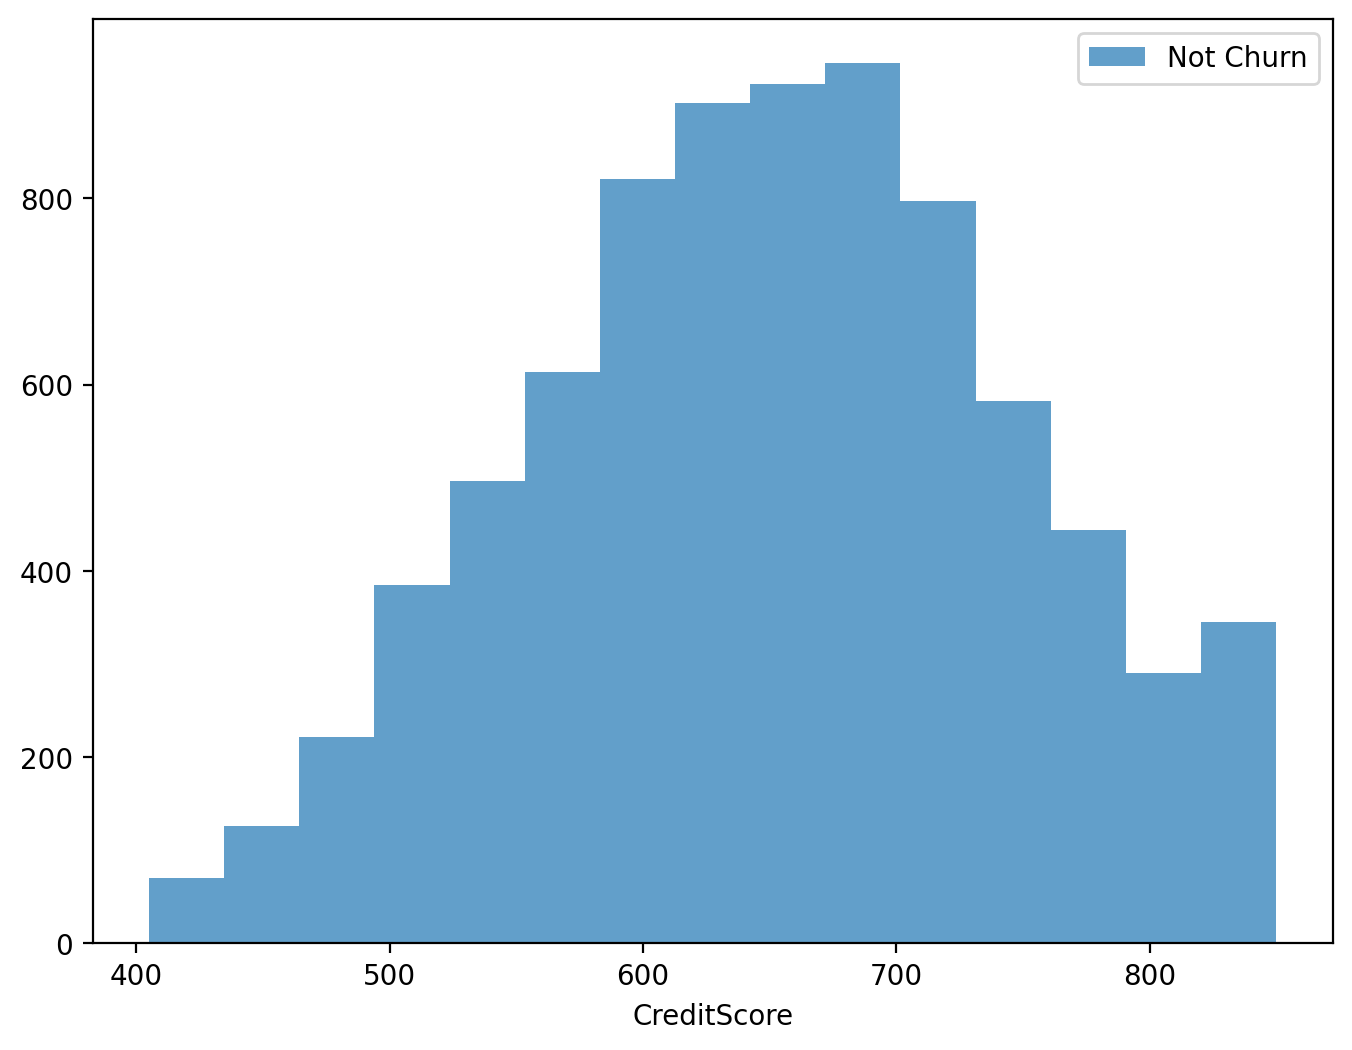

In [22]:
# distribution of the Credit Score for not_churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('CreditScore')
pyplot.hist(not_churn["CreditScore"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [23]:
churn["CreditScore"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    2037.000000
mean      645.351497
std       100.321503
min       350.000000
5%        479.000000
25%       578.000000
50%       646.000000
75%       716.000000
90%       776.400000
95%       812.200000
99%       850.000000
max       850.000000
Name: CreditScore, dtype: float64

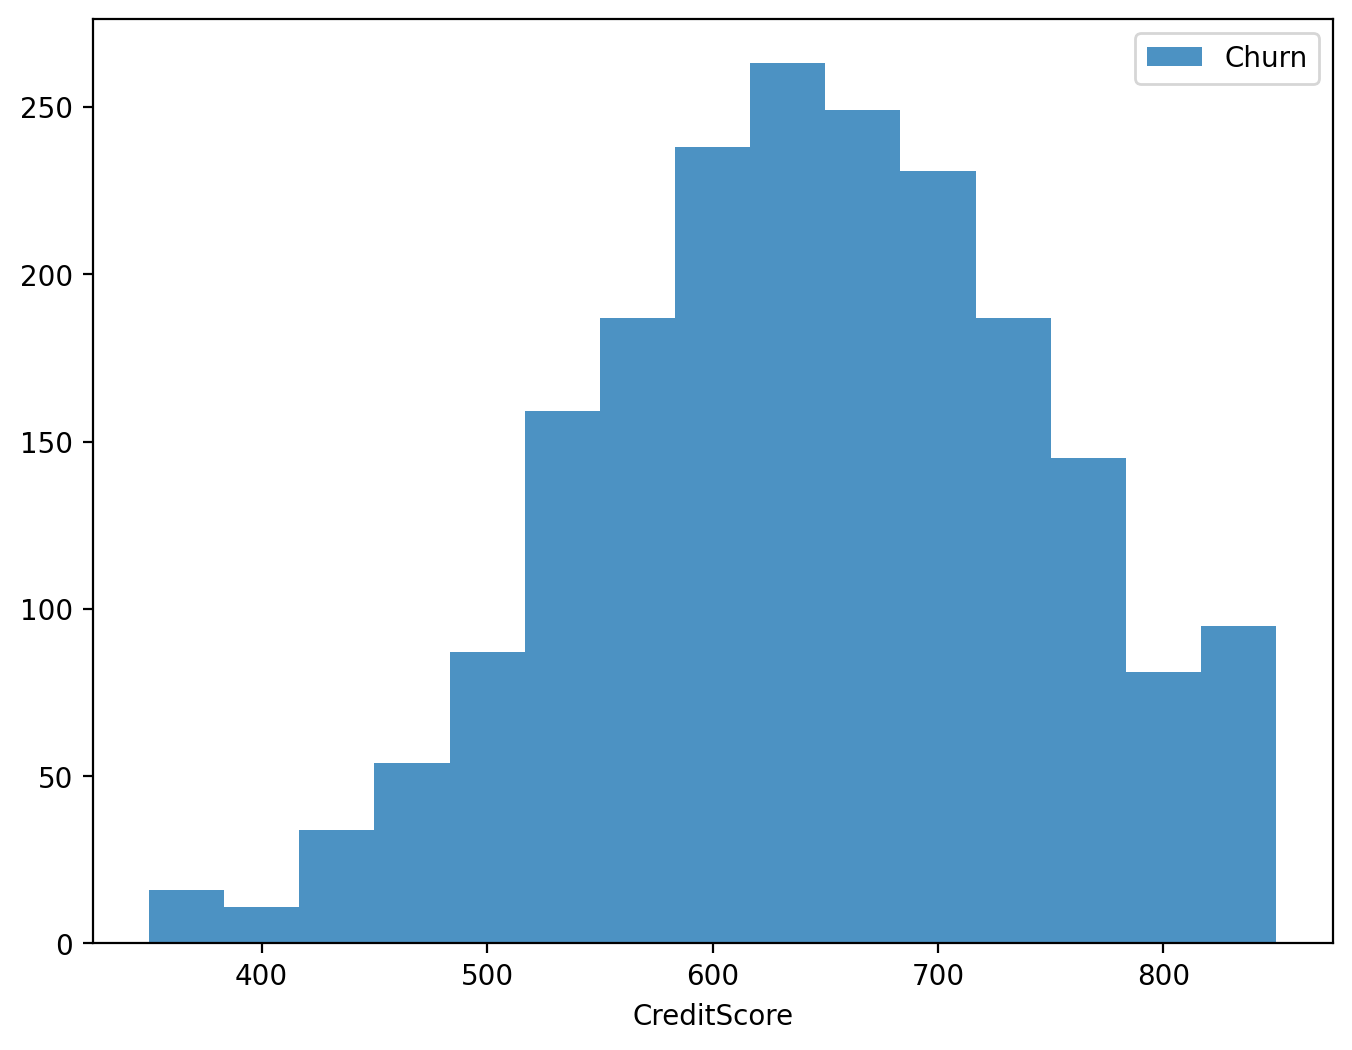

In [24]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('CreditScore')
pyplot.hist(churn["CreditScore"],bins=15, alpha=0.8, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

<Axes: >

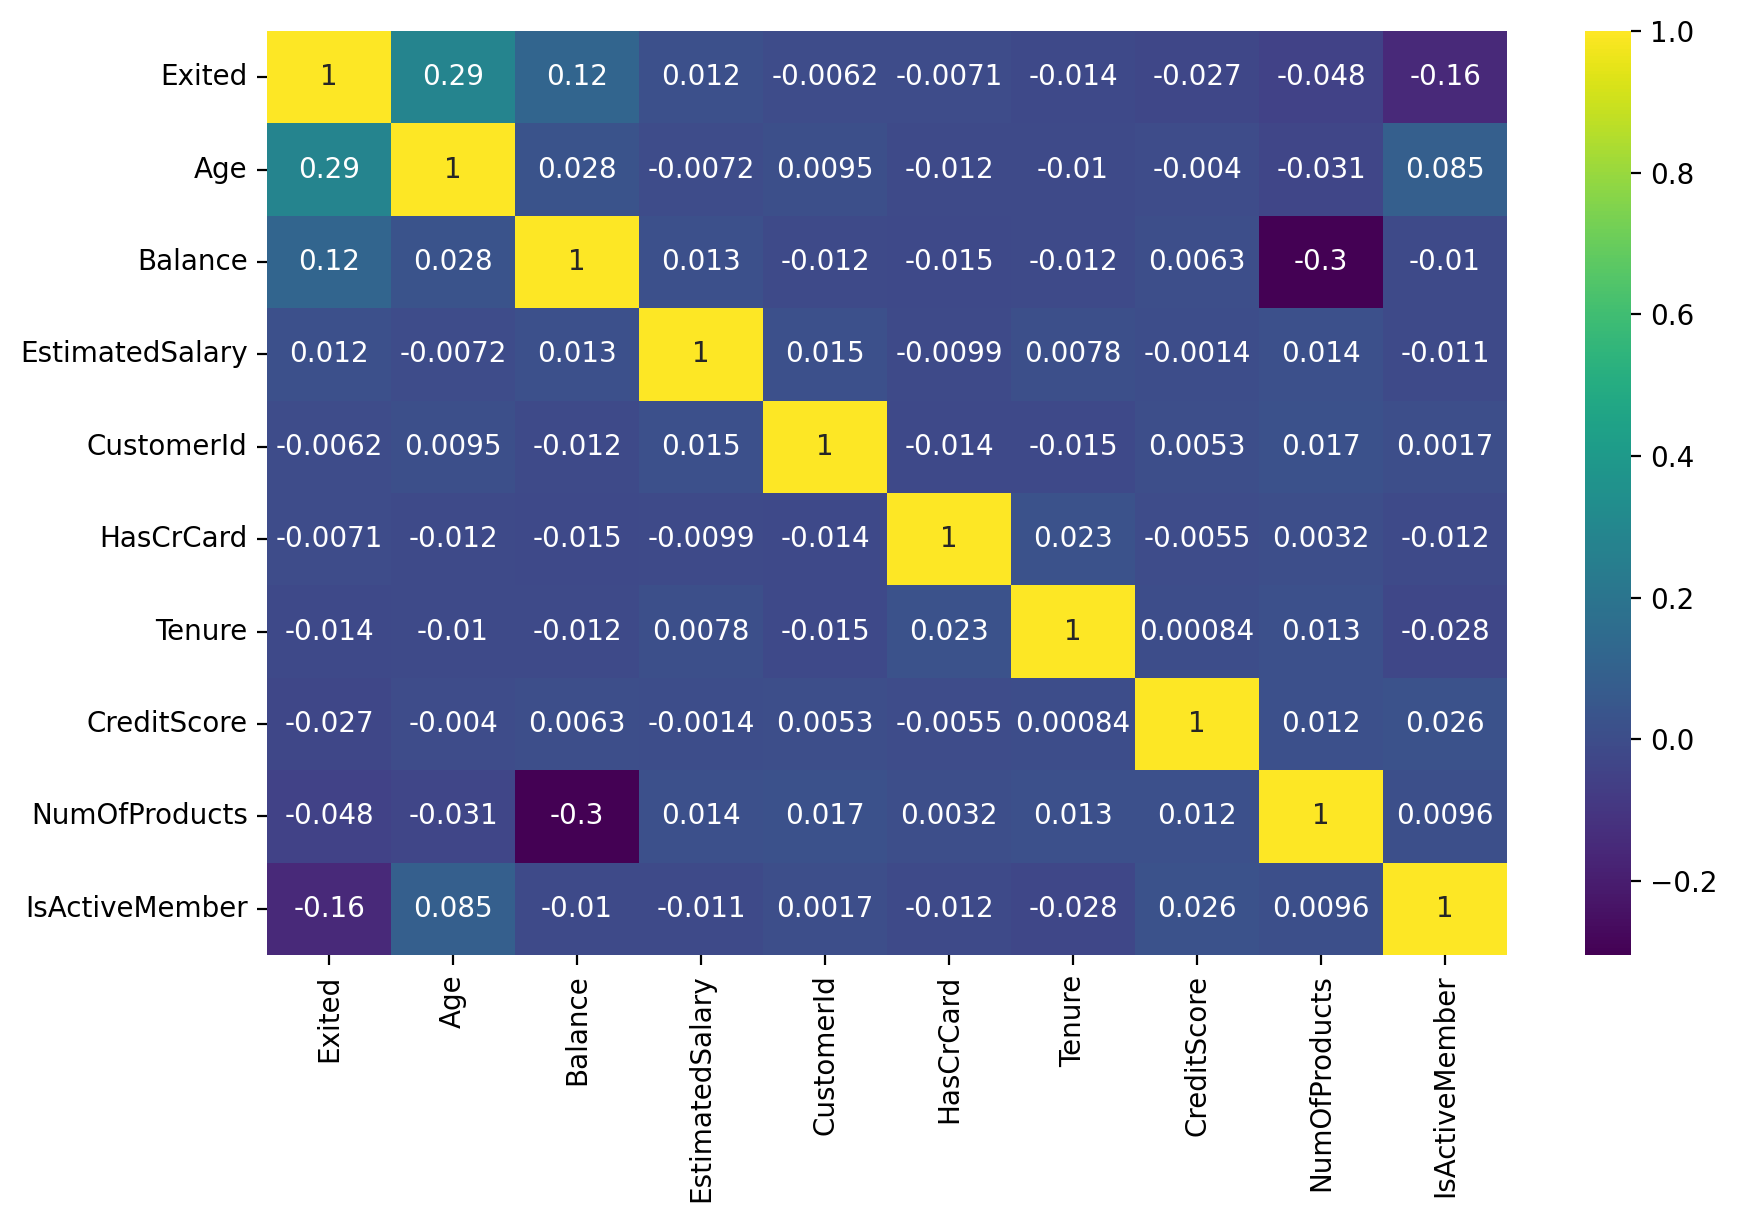

In [25]:
k = 10 #number of variables for heatmap
cols = df.corr().nlargest(k, 'Exited')['Exited'].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [31]:
df.isnull().sum()



CustomerId           0
Surname              0
CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Gender_Male          0
Geography_Germany    0
Geography_Spain      0
dtype: int64

In [32]:
def outlier_thresholds(dataframe, variable, low_quantile=0.05, up_quantile=0.95):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

In [33]:
def has_outliers(dataframe, numeric_columns, plot=False):
   # variable_names = []
    for col in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, " : ", number_of_outliers, "outliers")
            #variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()

In [34]:
for var in numeric_variables:
    print(var, "has " , has_outliers(df, [var]),  "Outliers")

CreditScore has  None Outliers
Age has  None Outliers
Balance has  None Outliers
EstimatedSalary has  None Outliers


In [35]:
# we standardize tenure with age
df["NewTenure"] = df["Tenure"]/df["Age"]
df["NewCreditsScore"] = pd.qcut(df['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
df["NewAgeScore"] = pd.qcut(df['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df["NewBalanceScore"] = pd.qcut(df['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df["NewEstSalaryScore"] = pd.qcut(df['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [36]:
df.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore
RowNumber,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,0,0,0,0.047619,3,6,1,6
2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,0.024390,2,6,3,6
3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0,0.190476,1,6,5,6
4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,0,0,0,0.025641,5,5,1,5
5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,0.046512,6,6,4,4


In [38]:
df = df.drop(["CustomerId","Surname"], axis = 1)

In [39]:
def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.01)
            quartile3 = variable.quantile(0.99)
            interquantile_range = quartile3 - quartile1
            z = (variable - var_median) / interquantile_range
            return round(z, 3)

        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

In [40]:
new_cols_ohe = ["Gender_Male","Geography_Germany","Geography_Spain"]
like_num = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) <= 10]
cols_need_scale = [col for col in df.columns if col not in new_cols_ohe
                   and col not in "Exited"
                   and col not in like_num]

for col in cols_need_scale:
    df[col] = robust_scaler(df[col])

In [41]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore
RowNumber,,,,,,,,,,,,,,,,,
1,-0.246,0.417,-0.75,-0.761,1,1,1,0.012,1,0,0,0,-0.217,3,6,1,6
2,-0.328,0.333,-1.00,-0.105,1,0,1,0.126,0,0,0,1,-0.279,2,6,3,6
3,-1.119,0.417,0.75,0.489,3,1,0,0.140,1,0,0,0,0.164,1,6,5,6
4,0.351,0.167,-1.00,-0.761,2,0,0,-0.065,0,0,0,0,-0.276,5,5,1,5
5,1.478,0.500,-0.75,0.222,1,1,1,-0.215,0,0,0,1,-0.220,6,6,4,4


In [43]:
# GB Confusion Matrix
model_GB = GradientBoostingClassifier(random_state=12345)
model_GB.fit(X_train, y_train)
y_pred = model_GB.predict(X_test)
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat


array([[1520,  230],
       [  53,  197]])

In [44]:
print("True Positive : ", conf_mat[1, 1])
print("True Negative : ", conf_mat[0, 0])
print("False Positive: ", conf_mat[0, 1])
print("False Negative: ", conf_mat[1, 0])

True Positive :  197
True Negative :  1520
False Positive:  230
False Negative:  53


In [52]:
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

In [45]:
print(classification_report(model_GB.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.97      0.87      0.91      1750
           1       0.46      0.79      0.58       250

    accuracy                           0.86      2000
   macro avg       0.71      0.83      0.75      2000
weighted avg       0.90      0.86      0.87      2000

